# Packages Installs, imports, and presets

In [1]:
#from scapy.all import *
import pandas as pd
#import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from collections import defaultdict
import os
from transformers import MobileViTV2Model, MobileViTV2Config
import torch
import torchmetrics
from torch import optim
import lightning as L
import torch
import torch.nn as nn

In [2]:
from lightning.pytorch.loggers import WandbLogger
import wandb
wandb.init() 

wandb: Currently logged in as: heitorwerneck (heitor57). Use `wandb login --relogin` to force relogin


In [3]:
INPUT_SIZE = (256,256,3)

# Removing missing features

In [4]:
TIMEOUT = 30

In [5]:
df_train= pd.read_parquet(f'data/iec104_train_{TIMEOUT}_v2.parquet')
df_validation = pd.read_parquet(f'data/iec104_validation_{TIMEOUT}_v2.parquet')
df_test=pd.read_parquet(f'data/iec104_test_{TIMEOUT}_v2.parquet')

In [6]:
def encode_time(df):
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df['hour'] = df['time'].dt.hour
    df['minute'] = df['time'].dt.minute
    df['second'] = df['time'].dt.second

    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    # Encode minute cyclically
    df['minute_sin'] = np.sin(2 * np.pi * df['minute'] / 60)
    df['minute_cos'] = np.cos(2 * np.pi * df['minute'] / 60)

    # Encode second cyclically
    df['second_sin'] = np.sin(2 * np.pi * df['second'] / 60)
    df['second_cos'] = np.cos(2 * np.pi * df['second'] / 60)
    df.drop('time',axis=1,inplace=True)
encode_time(df_train)
encode_time(df_validation)
encode_time(df_test)

In [7]:
from feature_engine.encoding import OrdinalEncoder
od = OrdinalEncoder(encoding_method='arbitrary')

feats=['ip_flags','ip_src','ip_dst','tcp_flags','label','tcp_sport', 'tcp_dport']

od.fit(df_train[feats])
df_train[feats] = od.transform(df_train[feats])
df_validation[feats] = od.transform(df_validation[feats])
df_test[feats] = od.transform(df_test[feats])

In [8]:
cols_to_drop = df_train.columns[df_train.nunique() == 1]
print(cols_to_drop)
# Drop these columns from the DataFrame
df_train = df_train.drop(cols_to_drop, axis=1)
df_validation = df_validation.drop(cols_to_drop, axis=1)
df_test = df_test.drop(cols_to_drop, axis=1)

Index(['ip_version', 'ip_ihl', 'ip_tos', 'ip_flags', 'ip_frag', 'ip_proto',
       'ip_options', 'tcp_reserved', 'tcp_flags', 'tcp_urgptr'],
      dtype='object')


In [9]:
df_train.columns

Index(['ip_len', 'ip_id', 'ip_ttl', 'ip_chksum', 'ip_src', 'ip_dst',
       'tcp_sport', 'tcp_dport', 'tcp_seq', 'tcp_ack', 'tcp_dataofs',
       'tcp_window', 'tcp_chksum', 'tcp_options', 'size', 'payload',
       'payload_raw', 'label', 'hour', 'minute', 'second', 'hour_sin',
       'hour_cos', 'minute_sin', 'minute_cos', 'second_sin', 'second_cos'],
      dtype='object')

In [10]:
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.preprocessing import MinMaxScaler
numeric_features = [
    'ip_len', 'ip_id', 'ip_ttl', 'ip_chksum',  'tcp_seq', 'tcp_ack',
    'tcp_dataofs', 'tcp_window', 'tcp_chksum', 'size'
]

# Initialize MinMaxScaler
scaler = SklearnTransformerWrapper(MinMaxScaler())
scaler.fit(df_train[numeric_features])
# Fit and transform the DataFrame
df_train[numeric_features] = scaler.transform(df_train[numeric_features])
df_test[numeric_features] = scaler.transform(df_test[numeric_features])
df_validation[numeric_features] = scaler.transform(df_validation[numeric_features])

In [11]:
def reset_indexes(df):
    return df.reset_index('packet_number',inplace=True)
reset_indexes(df_train)
reset_indexes(df_test)
reset_indexes(df_validation)

In [12]:
df_train.shape

(331760, 28)

In [13]:
# df_train[df_train.dtypes=='object']

In [14]:
display(df_train['label'].value_counts())
display(df_validation['label'].value_counts())
display(df_test['label'].value_counts())

label
1     140078
0     116152
8      13064
9      12755
11     10685
6       7320
5       6944
10      6909
7       5769
3       4439
4       4329
2       3316
Name: count, dtype: int64

label
1     35254
0     28848
8      3254
9      3188
11     2661
6      1789
5      1741
10     1736
7      1465
3      1108
4      1090
2       807
Name: count, dtype: int64

label
1     44080
0     36175
8      4097
9      3932
11     3222
6      2285
10     2192
5      2133
7      1763
4      1384
3      1382
2      1031
Name: count, dtype: int64

In [15]:
df_train

,packet_number,ip_len,ip_id,ip_ttl,ip_chksum,ip_src,ip_dst,tcp_sport,tcp_dport,tcp_seq,...,label,hour,minute,second,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos
flow,,,,,,,,,,,,,,,,,,,,,
"[1, '192.168.1.20', '192.168.1.24', 2404, 50409, 'TCP', 'c_rp_na_1_DoS']",3483,0.121951,0.051926,1.0,0.413953,0,0,2404,50409,0.499231,...,1,18,33,53,-1.000000,-1.836970e-16,-0.309017,-9.510565e-01,-0.669131,0.743145
"['192.168.1.19', '192.168.1.20', 2404, 3, 50050, 'TCP', 'm_sp_na_1_DoS']",8161,0.121951,0.458701,1.0,0.007248,1,0,2404,50050,0.686169,...,0,0,25,56,0.000000,1.000000e+00,0.500000,-8.660254e-01,-0.406737,0.913545
"[1, '192.168.1.20', '192.168.1.22', 2404, 49671, 'TCP', 'c_sc_na_1_DoS']",750,0.000000,0.375296,1.0,0.090762,2,0,2404,49671,0.384941,...,1,11,53,54,0.258819,-9.659258e-01,-0.669131,7.431448e-01,-0.587785,0.809017
"[1, '192.168.1.20', '192.168.1.25', 2404, 50047, 'TCP', 'm_sp_na_1_DoS']",2152,0.317073,0.402106,1.0,0.063509,3,0,2404,50047,0.059388,...,0,21,45,28,-0.707107,7.071068e-01,-1.000000,-1.836970e-16,0.207912,-0.978148
"[1, '192.168.1.19', '192.168.1.29', 2404, 39873, 'TCP', 'c_rd_na_1_DoS']",5,0.146341,0.490196,1.0,0.975600,1,1,2404,39873,0.387383,...,8,20,0,26,-0.866025,5.000000e-01,0.000000,1.000000e+00,0.406737,-0.913545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"[1, '192.168.1.19', '192.168.1.29', 2404, 34591, 'TCP', 'c_rp_na_1_DoS']",5,0.146341,0.392523,0.0,0.323267,7,2,34591,2404,0.267499,...,9,15,47,58,-0.707107,-7.071068e-01,-0.978148,2.079117e-01,-0.207912,0.978148
"[1, '192.168.1.20', '192.168.1.21', 2404, 50705, 'TCP', 'c_rd_na_1_DoS']",579,0.000000,0.263813,1.0,0.202261,5,0,2404,50705,0.958725,...,1,17,13,17,-0.965926,-2.588190e-01,0.978148,2.079117e-01,0.978148,-0.207912
"[1, '192.168.1.20', '192.168.1.24', 2404, 50046, 'TCP', 'm_sp_na_1_DoS']",2856,0.317073,0.435813,1.0,0.029817,0,0,2404,50046,0.303676,...,0,21,50,16,-0.707107,7.071068e-01,-0.866025,5.000000e-01,0.994522,-0.104528


In [16]:
tmp=df_train.groupby('flow')['ip_id'].count().value_counts()
tmp=tmp.sort_index().cumsum()
tmp = tmp/tmp.max()
display(tmp)

ip_id
1        0.003617
2        0.032253
3        0.120526
4        0.303343
5        0.550594
           ...   
6191     0.999705
16237    0.999779
16356    0.999852
16963    0.999926
17538    1.000000
Name: count, Length: 139, dtype: float64

In [17]:
# df_train.drop('payload_raw')

In [18]:
def payload_to_binary_columns(df, column_name):
    """
    Converts a column with binary data into separate bit columns.

    Args:
        df (pd.DataFrame): The input DataFrame.
        column_name (str): The name of the column to convert.

    Returns:
        pd.DataFrame: The transformed DataFrame with bit columns.
    """
    # Find the maximum length of the payload
    max_payload_length = df[column_name].apply(len).max()
    bit_columns = ['bit_' + str(i) for i in range(max_payload_length * 8)]
    
    def bytes_to_bits(byte_data):
        byte_array = np.frombuffer(byte_data, dtype=np.uint8)
        return np.unpackbits(byte_array)
    
    # Convert and pad the binary data
    binary_data = df[column_name].apply(lambda x: np.pad(bytes_to_bits(x), (0, max_payload_length * 8 - len(x) * 8), 'constant'))

    # Stack the binary data into a matrix
    binary_matrix = np.vstack(binary_data.values)
    
    # Create a DataFrame from the binary matrix
    binary_df = pd.DataFrame(binary_matrix, columns=bit_columns)
    df=df.reset_index()
    # Concatenate the binary DataFrame with the original DataFrame
    return pd.concat([df.drop(columns=[column_name]), binary_df], axis=1).set_index('flow')
# Transform the DataFrame
df_train=payload_to_binary_columns(df_train, 'payload_raw')
df_validation=payload_to_binary_columns(df_validation, 'payload_raw')
df_test=payload_to_binary_columns(df_test, 'payload_raw')

In [19]:
df_test['label']=df_test['label'].astype(int)
df_train['label']=df_train['label'].astype(int)
df_validation['label']=df_validation['label'].astype(int)

# Training Dataset

In [40]:
import torch.utils.data as data_utils
import torch.nn.functional as F
from torch.utils.data import Dataset
SEQ_LEN = 20
BATCH_SIZE=96

class IEC104Dataset(Dataset):
    def __init__(self, df, transform=None, target_transform=None):
        self.df = df
        self.flow_int_id = list(set(self.df.index))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.flow_int_id)

    def __getitem__(self, idx):
        df_idx = self.flow_int_id[idx]
        flow = self.df.loc[df_idx, self.df.columns != 'label']
        label = self.df.loc[df_idx, 'label']

        if isinstance(flow, pd.Series):
            flow = flow.to_frame().T
        
        # if isinstance(label, np.float64):
        #     print('label:',label)
        if isinstance(label,np.float64):
            label = label.astype(int)
        elif not isinstance(label, np.int64):
            label = label.iloc[0]
        label = torch.tensor(label)

        if self.transform:
            flow = self.transform(flow)
        if self.target_transform:
            label = self.target_transform(label)
        # print(flow)
        # print(label)
        return flow, label

def feature_transform(flow):
    # Convert flow to a DataFrame if it's not already
    flow = pd.DataFrame(flow)

    # Convert to tensors
    dynamic_tensor = torch.tensor(flow.values, dtype=torch.float32)

    if dynamic_tensor.shape[0] > SEQ_LEN:
        # Randomly select a starting index for the sequence
        start_idx = np.random.randint(0, dynamic_tensor.shape[0] - SEQ_LEN + 1)
        dynamic_tensor = dynamic_tensor[start_idx:start_idx + SEQ_LEN]
    else:
        # If the tensor is shorter than SEQ_LEN, pad with -1 as before
        X = -torch.ones(SEQ_LEN, dynamic_tensor.shape[1], dtype=torch.float32)
        min_shape_0 = min(dynamic_tensor.shape[0], SEQ_LEN)
        X[:min_shape_0] = dynamic_tensor[-min_shape_0:]
        dynamic_tensor = X
    # dynamic_tensor = (dynamic_tensor+1)/2
    return dynamic_tensor

    # return dynamic_tensor
NUM_WORKERS =6
PREFETCH_FACTOR=2
train_dataset = IEC104Dataset(df_train,transform = feature_transform)
validation_dataset = IEC104Dataset(df_validation,transform = feature_transform)
test_dataset = IEC104Dataset(df_test,transform = feature_transform)

### Dataset Loader

In [41]:
train_dataset.df.groupby('flow')['label'].unique()

flow
['192.168.1.13', '192.168.1.20', 2, 2404, 50049, 'TCP', 'm_sp_na_1_DoS']     [0]
['192.168.1.13', '192.168.1.20', 2404, 3, 50049, 'TCP', 'm_sp_na_1_DoS']     [0]
['192.168.1.13', '192.168.1.20', 2404, 4, 50049, 'TCP', 'm_sp_na_1_DoS']     [0]
['192.168.1.13', '192.168.1.29', 2, 2404, 34087, 'TCP', 'c_rd_na_1_DoS']     [8]
['192.168.1.13', '192.168.1.29', 2, 2404, 34693, 'TCP', 'c_rp_na_1']         [6]
                                                                            ... 
[1, '192.168.1.26', '192.168.1.27', 2404, 46843, 'TCP', 'c_sc_na_1']         [4]
[1, '192.168.1.26', '192.168.1.27', 2404, 46845, 'TCP', 'c_rd_na_1_DoS']     [8]
[1, '192.168.1.26', '192.168.1.27', 2404, 46849, 'TCP', 'c_rd_na_1_DoS']     [8]
[1, '192.168.1.26', '192.168.1.27', 2404, 46851, 'TCP', 'c_sc_na_1_DoS']    [11]
[1, '192.168.1.26', '192.168.1.27', 2404, 46879, 'TCP', 'c_se_na_1_DoS']    [10]
Name: label, Length: 13549, dtype: object

In [42]:
class_sample_output=df_train.reset_index().groupby('label')['flow'].nunique().tolist()
# print(class_sample_output)
sampling_weights = 1 / torch.Tensor(class_sample_output)
# print(sampling_weights)

labels = train_dataset.df.groupby('flow')['label'].unique()
# print(train_dataset.flow_int_id[0])
labels=[labels.loc[i][0] for i in train_dataset.flow_int_id]
samples_weight = np.array([sampling_weights[t] for t in labels]).flatten()

samples_weight = torch.from_numpy(samples_weight)
samples_weigth = samples_weight.double()
# print(samples_weigth)
sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight, len(samples_weight))


# train_loader = data_utils.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR)
train_loader = data_utils.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR,sampler = sampler)#,collate_fn = collate_fn)
# train_loader = data_utils.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR)
# next(iter(train_loader))

validation_loader = data_utils.DataLoader(dataset = validation_dataset, batch_size = BATCH_SIZE,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR)#,collate_fn = collate_fn)
test_loader = data_utils.DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR)#,collate_fn = collate_fn)

# next(iter(train_loader))

In [43]:
b = next(iter(test_loader))

# Model Design

In [44]:
# model_vitv2_output_shape = [ 512, 8, 8]
NUM_CLASSES = df_train.label.nunique()

In [45]:
def get_device():
    device = "cpu"
    if torch.cuda.is_available():
      device = "cuda"
    return device
DEVICE = get_device()

In [46]:
import seaborn as sns

In [47]:
import wandb

### Lightning

In [48]:
class LFVIT(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.step_outputs = defaultdict(list)
        self.step_target = defaultdict(list)
    def forward(self, inputs):
        return self.model(inputs)
    def training_step(self, batch, batch_idx):
        x, y = batch
        target_prediction = self.model(x)
        loss = nn.functional.cross_entropy(target_prediction, y)
        self.step_outputs['train'].append(target_prediction)
        self.step_target['train'].append(y)
        self.log('train_loss',loss,on_epoch=True,on_step=False)
        return loss
    def validation_step(self, batch, batch_idx):
        x, y = batch
        target_prediction = self.model(x)
        self.step_outputs['validation'].append(target_prediction)
        self.step_target['validation'].append(y)
        loss = nn.functional.cross_entropy(target_prediction, y)
        self.log('val_loss',loss,on_epoch=True,on_step=False)
        # loss = nn.functional.cross_entropy(target_prediction, y)
        # self.log('val_loss',loss)
    def test_step(self, batch, batch_idx):
        x, y = batch
        target_prediction = self.model(x)
        self.step_outputs['test'].append(target_prediction)
        self.step_target['test'].append(y)       
    # def on_test_epoch_end(self):
    # def on_train_epoch_end(self):

    def on_test_epoch_end(self):
        self._shared_on_epoch_end(end_type='test')
    def on_validation_epoch_end(self):
        self._shared_on_epoch_end('validation')
    def on_train_epoch_end(self):
        self._shared_on_epoch_end(end_type='train')
    def _shared_on_epoch_end(self,end_type):
        # print(end_type)
        # print(len(self.step_outputs))
        all_preds = torch.cat(self.step_outputs[end_type])
        all_targets = torch.cat(self.step_target[end_type])
        # all_preds=torch.flatten(all_preds,start_dim=0,end_dim=1)
        # all_targets=torch.flatten(all_targets,start_dim=0,end_dim=1)
        # print(all_preds[:])
        # print(all_targets.shape)
        # print(all_preds.shape)
        # print(all_targets[:5])
        # print(all_preds[:5])
        metrics = dict()
        suffix= end_type+'_'
        # print(all_preds.shape)
        # print(all_targets.shape)        
        accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
        metrics[suffix+'accuracy'] = accuracy(all_preds, all_targets)
        
        accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES,average='macro').to(DEVICE)
        metrics[suffix+'accuracy_macro'] = accuracy(all_preds, all_targets)

        confusionmatrix = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
        confusionmatrix_result = confusionmatrix(all_preds, all_targets).cpu().numpy()
        df_cm = pd.DataFrame(confusionmatrix_result, index = range(NUM_CLASSES), columns=range(NUM_CLASSES))
        
        plt.figure(figsize = (10,7))
        fig_ = sns.heatmap(df_cm, annot=True, cmap='Spectral').get_figure()
        plt.close(fig_)
        fig_.savefig('tmp/confusionmatrix.png')
        wandb_logger.log_image(key=suffix+"confusionmatrix", images=['tmp/confusionmatrix.png'])
        
        confusionmatrix = torchmetrics.ConfusionMatrix(normalize='true',task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
        confusionmatrix_result = confusionmatrix(all_preds, all_targets).cpu().numpy()
        df_cm = pd.DataFrame(confusionmatrix_result, index = range(NUM_CLASSES), columns=range(NUM_CLASSES))
        plt.figure(figsize = (10,7))
        fig_ = sns.heatmap(df_cm, annot=True, cmap='Spectral').get_figure()
        plt.close(fig_)
        fig_.savefig('tmp/confusionmatrix_normalized.png')
        wandb_logger.log_image(key=suffix+"confusionmatrix_normalized", images=['tmp/confusionmatrix_normalized.png'])
        
        self.log_dict(metrics)
        self.step_outputs[end_type].clear()
        self.step_target[end_type].clear()
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=1e-4)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min')
        return {'optimizer':optimizer,"lr_scheduler":{"scheduler": scheduler, "interval": "epoch","frequency": 1,"monitor": "val_loss"}}


In [49]:

# accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)

# accuracy(torch.tensor(4, device='cuda:0'),
# torch.tensor([0.0824, 0.0977, 0.1032, 0.0896, 0.0766, 0.1045, 0.0956, 0.0752, 0.0876,
#         0.0868, 0.1010], device='cuda:0'))

###  FVIT


In [50]:
import math

class FVIT(nn.Module):
    def __init__(self,encoder,decoder):
        super(FVIT, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        hidden_states=self.encoder(x[0])
        concatenated_input = torch.cat((torch.flatten(hidden_states, start_dim=1), torch.flatten(x[1], start_dim=1)),dim=1)
        return self.decoder(concatenated_input)
    
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model)
        # print(x.shape)
        x = x + self.pe[:, :x.size(1), :]  # Shape: (batch_size, seq_len, d_model)
        return x

class TransformerModel(nn.Module):
    def __init__(self,d_model, nhead, nhid, nlayers, dropout):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model,SEQ_LEN)
        # print(d_model,nhead,dropout,nhid)
        self.transformer_encoder = nn.TransformerEncoder(
                        nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout,dim_feedforward=nhid,activation=nn.ReLU(),batch_first=True),
                num_layers=nlayers,norm=nn.LayerNorm(normalized_shape=NUM_FEATURES)
                )
        self.d_model = d_model
        self.decoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(NUM_FEATURES*SEQ_LEN, NUM_CLASSES),
            # nn.Dropout(0.5),
            # nn.ReLU(),
            # nn.Linear(100, NUM_CLASSES),
            nn.Softmax(dim=1)
)   
    # def init_weights(self):
    #     initrange = 0.1
    #     self.transformer_encoder.bias.data.zero_()
    #     self.transformer_encoder.weight.data.uniform_(-initrange, initrange)
        
    def forward(self, x):
        # print('fow',x.shape)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        # print(x.shape)
        # print("DD:",x)
        x= self.decoder(x)
        # return output
        return x

In [51]:
NUM_FEATURES = df_train.shape[1]-1
NUM_FEATURES

730

In [52]:
output_dim_transformer_encoder = [SEQ_LEN,SEQ_LEN,NUM_FEATURES]

In [53]:
NUM_FEATURES

730

In [54]:
from x_transformers import Encoder


In [55]:


class BinaryEncodingTransformerModel(nn.Module):
    def __init__(self):
        super(BinaryEncodingTransformerModel, self).__init__()
        self.model_type = 'Transformer'
        # self.embedding = nn.Sequential(
        #     # nn.Flatten(),
        #             nn.Linear(NUM_FEATURES,100),
        #             nn.LeakyReLU(),
        #             # nn.Linear(200,50),
        #             # nn.LeakyReLU(),
        #                                )
        
        self.decoder = nn.Sequential(
    PositionalEncoding(NUM_FEATURES,SEQ_LEN),
    Encoder(dim = 100,
        depth = 2,
        heads = 4,
           ff_dropout = 0.2,          # feed-forward dropout rate
    attn_dropout = 0.2,         # attention dropout rate
    # attn_sparse_topk = 8
        ),
            nn.Flatten(),
            nn.Linear(NUM_FEATURES*SEQ_LEN, NUM_CLASSES),
            # nn.Linear(NUM_FEATURES*SEQ_LEN, 1000),
            # nn.ReLU(),
            # nn.Linear(1000, 200),
            # nn.ReLU(),
            # nn.Dropout(0.1),
            # nn.Linear(200, NUM_CLASSES),
            
            nn.Softmax(dim=1)
)
    # def init_weights(self):
    #     initrange = 0.1
    #     self.transformer_encoder.bias.data.zero_()
    #     self.transformer_encoder.weight.data.uniform_(-initrange, initrange)
        
    def forward(self, x):
        # print('fow',x.shape)
        # batch_size, seq_len, _ = x.shape
        # x = x.view(batch_size * seq_len, -1)
        # x = self.embedding(x)
        # x = x.view(batch_size, seq_len, -1)
        # xs = []
        # for i in range(SEQ_LEN):
        #     xs.append(self.embedding(x[:,i,:]))
        # x = torch.stack(xs,dim=1)
        # print(x.shape)
        # x =  x.view(BATCH_SIZE, SEQ_LEN, 50)
        x = self.decoder(x)
        return x
# model_vitv2 = MobileViTV2Model.from_pretrained("apple/mobilevitv2-1.0-imagenet1k-256")
# model_vitv2 = MobileViTV2Model(config=MobileViTV2Config())
# d_model+num_static_features, num_classes


# D_MODEL = num_dynamic_features


# decoder=nn.Sequential(
#     # nn.Flatten(),
#     # nn.Linear(num_dynamic_features*SEQ_LEN+num_static_features, 1500),
#     # nn.Linear(num_dynamic_features*SEQ_LEN+num_static_features, NUM_CLASSES),
#     nn.Linear(num_dynamic_features*SEQ_LEN+num_static_features, 100),
#     nn.ReLU(),
#     nn.Linear(100, NUM_CLASSES),
#     nn.Softmax(dim=1)
# )
# model_fvit = LFVIT(BinaryEncodingTransformerModel())

# model_fvit = LFVIT(TransformerModel(d_model=NUM_FEATURES, nhead=2, nhid=2048, nlayers=4, dropout=0))
# model_fvit = LFVIT(nn.Sequential(
#     PositionalEncoding(NUM_FEATURES,SEQ_LEN),
#     Encoder(dim = NUM_FEATURES,
#         depth = 2,
#         heads = 4,
#            ff_dropout = 0.2,          # feed-forward dropout rate
#     attn_dropout = 0.2,         # attention dropout rate
#     # attn_sparse_topk = 8
#         ),
#             nn.Flatten(),
#             nn.Linear(NUM_FEATURES*SEQ_LEN, NUM_CLASSES),
#             # nn.Linear(NUM_FEATURES*SEQ_LEN, 1000),
#             # nn.ReLU(),
#             # nn.Linear(1000, 200),
#             # nn.ReLU(),
#             # nn.Dropout(0.1),
#             # nn.Linear(200, NUM_CLASSES),
            
#             nn.Softmax(dim=1)
# ))

model_fvit = LFVIT(nn.Sequential(
    # nn.Linear(NUM_FEATURES*SEQ_LEN, 50*SEQ_LEN),
    PositionalEncoding(NUM_FEATURES,SEQ_LEN),
    Encoder(dim = NUM_FEATURES,
        depth = 6,
        heads = 4,
           ff_dropout = 0.2,          # feed-forward dropout rate
    attn_dropout = 0.2,         # attention dropout rate
    # attn_sparse_topk = 8
        ),
            nn.Flatten(),
            nn.Linear(NUM_FEATURES*SEQ_LEN, NUM_CLASSES),
            # nn.Linear(NUM_FEATURES*SEQ_LEN, 1000),
            # nn.ReLU(),
            # nn.Linear(1000, 200),
            # nn.ReLU(),
            # nn.Dropout(0.1),
            # nn.Linear(200, NUM_CLASSES),
            
            nn.Softmax(dim=1)
))

In [56]:
model_fvit.model

Sequential(
  (0): PositionalEncoding()
  (1): Encoder(
    (layers): ModuleList(
      (0): ModuleList(
        (0): ModuleList(
          (0): LayerNorm((730,), eps=1e-05, elementwise_affine=True)
          (1-2): 2 x None
        )
        (1): Attention(
          (to_q): Linear(in_features=730, out_features=256, bias=False)
          (to_k): Linear(in_features=730, out_features=256, bias=False)
          (to_v): Linear(in_features=730, out_features=256, bias=False)
          (attend): Attend(
            (attn_dropout): Dropout(p=0.2, inplace=False)
          )
          (to_out): Linear(in_features=256, out_features=730, bias=False)
        )
        (2): Residual()
      )
      (1): ModuleList(
        (0): ModuleList(
          (0): LayerNorm((730,), eps=1e-05, elementwise_affine=True)
          (1-2): 2 x None
        )
        (1): FeedForward(
          (ff): Sequential(
            (0): Sequential(
              (0): Linear(in_features=730, out_features=2920, bias=True)
  

In [57]:
# model_vitv2 = MobileViTV2Model.from_pretrained("apple/mobilevitv2-1.0-imagenet1k-256")
# # model_vitv2 = MobileViTV2Model(config=MobileViTV2Config())
# # d_model+num_static_features, num_classes


# # D_MODEL = num_dynamic_features


# decoder=nn.Sequential(
#     # nn.Flatten(),
#     # nn.Linear(num_dynamic_features*SEQ_LEN+num_static_features, 1500),
#     # nn.Linear(num_dynamic_features*SEQ_LEN+num_static_features, NUM_CLASSES),
#     nn.Linear(num_dynamic_features*SEQ_LEN+num_static_features, 100),
#     nn.ReLU(),
#     # nn.Dropout(dropout),
#     # nn.Linear(1500, 100),
#     # nn.LeakyReLU(),
#     # nn.Dropout(dropout),
#     nn.Linear(100, NUM_CLASSES),
#     nn.Softmax(dim=1)
# )
# transformer_encoder = TransformerModel(d_model=num_dynamic_features, nhead=6, nhid=2048, nlayers=3, dropout=0.01)

# fvit = FVIT(transformer_encoder,decoder)
# model_fvit = LFVIT(fvit)

## Running


In [58]:
from lightning.pytorch.callbacks import LearningRateMonitor

In [59]:
wandb.finish()
wandb_logger = WandbLogger(log_model="all")

MAX_EPOCHS=200
# timer =  L.pytorch.calalbacks.Timer()
def run_fvit_trainer_fit(train_loader,validation_loader,model):
    checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
        monitor='train_loss',
        filename='iec104-{epoch:02d}-{loss}',
        save_top_k=1,
        mode='min', 
    )
    lr_monitor = LearningRateMonitor(logging_interval='epoch')
    # early_stop_callback = L.pytorch.callbacks.early_stopping.EarlyStopping(monitor="val_loss", min_delta=0.001, patience=3, verbose=False, mode="min")
    # cpb=CustomProgressBar()
    trainer = L.Trainer(max_epochs=MAX_EPOCHS,callbacks=[checkpoint_callback,lr_monitor],accelerator=DEVICE,
                        devices=1,log_every_n_steps=20
                        #,check_val_every_n_epoch=1
                        # ,limit_train_batches=100,limit_val_batches=100#,max_time={"minutes": 60}
                        ,logger=wandb_logger)
    trainer.fit(model=model, train_dataloaders=train_loader,val_dataloaders=validation_loader)
    return checkpoint_callback,trainer
checkpoint_callback,trainer=run_fvit_trainer_fit(
    train_loader,
    validation_loader,
     model=model_fvit)

epoch,▁▁██
lr-AdamW,▁▁▁
train_accuracy,▁█
train_accuracy_macro,▁█
train_loss,█▁
trainer/global_step,▁▁▁▄▄▄▄▅▅▅█████
val_loss,▁█
validation_accuracy,█▁
validation_accuracy_macro,█▁
epoch,1
lr-AdamW,0.0001


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 30.3 M
-------------------------------------
30.3 M    Trainable params
0         Non-trainable params
30.3 M    Total params
121.084   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

/home/hwerneck/miniconda3/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: 12 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)  # noqa: B028


Training: |                                                                                                   …

In [ ]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

ValueError: path must be a valid string

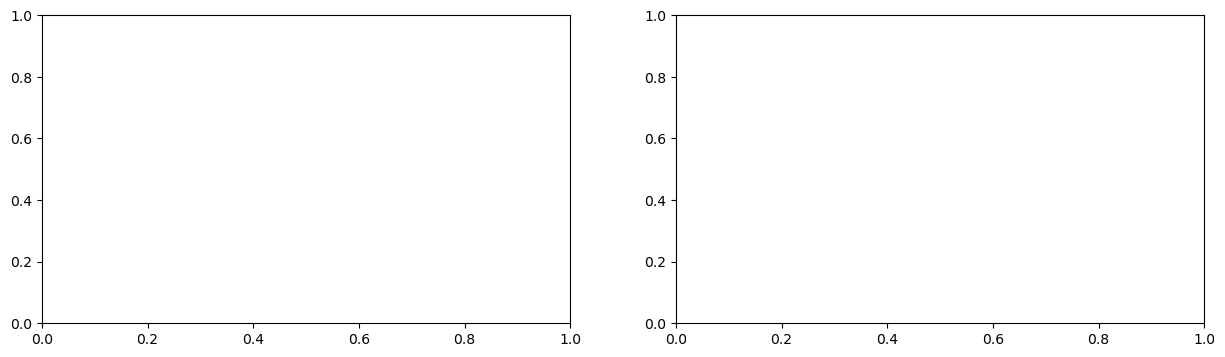

In [ ]:
def plot_training_metrics(trainer,metrics,ax):
    event_acc = EventAccumulator(trainer.logger.log_dir)
    event_acc.Reload()
    for i in range(len(metrics)):
        y=[i.value for i in event_acc.Scalars(metrics[i]['name'])]
        x=np.arange(len(y))+1
        ax[i].plot(x,y,marker='.')
        ax[i].set_xlabel("Epoch")
        ax[i].set_ylabel(metrics[i]['label'])
metrics=[{'name':'train_loss','label':'Training MSE Loss'},{'name':'val_loss','label':'Validation MSE Loss'}]
fig,ax = plt.subplots(ncols=len(metrics),figsize=(15,4))
plot_training_metrics(trainer,metrics,ax)

In [ ]:
metrics=[{'name':'train_accuracy','label':'Training Accuracy'},{'name':'val_accuracy','label':'Validation Accuracy'}]
fig,ax = plt.subplots(ncols=len(metrics),figsize=(15,4))
plot_training_metrics(trainer,metrics,ax)

In [ ]:
trainer.test(ckpt_path="best",dataloaders=test_loader)

In [ ]:
# class ImageFCN(nn.Module):
#     def __init__(self,fcn):
#         super(FVIT, self).__init__()
#         self.fcn = fcn

#     def forward(self, x):
#         return self.fcn(torch.flatten(x))
# ImageFCN(FullyConnectedNet())

In [ ]:
# MAX_EPOCHS=50
# # timer =  L.pytorch.calalbacks.Timer()
# def run_fvit_trainer_fit(train_loader,validation_loader,model):
#     checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
#         monitor='train_loss',
#         filename='iec104-{epoch:02d}-{loss:.2f}',
#         save_top_k=3,
#         mode='min',
#     )

#     early_stop_callback = L.pytorch.callbacks.early_stopping.EarlyStopping(monitor="val_loss", min_delta=0.001, patience=3, verbose=False, mode="min")
#     # cpb=CustomProgressBar()
#     trainer = L.Trainer(max_epochs=MAX_EPOCHS,callbacks=[checkpoint_callback,early_stop_callback],accelerator=DEVICE,
#                         devices=1,log_every_n_steps=10,limit_train_batches=0.1,limit_val_batches=0.1,max_time={"minutes": 5})
#     trainer.fit(model=model, train_dataloaders=train_loader,val_dataloaders=validation_loader)
#     return checkpoint_callback,trainer
# checkpoint_callback,trainer=run_fvit_trainer_fit(
#     train_loader,
#     validation_loader,
#      model=model_fvit)

In [ ]:
class FVIT(nn.Module):
    def __init__(self,encoder,decoder):
        super(FVIT, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        hidden_states=self.encoder(x[0]).last_hidden_state
        # print("Hidden states shape:", hidden_states.shape)
        # print("Additional input shape:", x[1].shape)
        # print("Concatenated input shape:", concatenated_input.shape)
        return self.decoder(hidden_states)
decoder= nn.Sequential(nn.Flatten(),
                       nn.Linear(512*8*8, NUM_CLASSES),
                         nn.Softmax(dim=1)
                   )
# model_fvit=FVIT(model_vitv2,decoder)

In [ ]:
fvit = FVIT(model_vitv2,decoder)
model_fvit = LFVIT(fvit)

In [ ]:
MAX_EPOCHS=50
# timer =  L.pytorch.calalbacks.Timer()
def run_fvit_trainer_fit(train_loader,validation_loader,model):
    checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
        monitor='train_loss',
        filename='iec104-{epoch:02d}-{loss}',
        save_top_k=3,
        mode='min',
    )

    # early_stop_callback = L.pytorch.callbacks.early_stopping.EarlyStopping(monitor="val_loss", min_delta=0.001, patience=3, verbose=False, mode="min")
    # cpb=CustomProgressBar()
    trainer = L.Trainer(max_epochs=MAX_EPOCHS,callbacks=[checkpoint_callback],accelerator=DEVICE,
                        devices=1,log_every_n_steps=10,limit_train_batches=0.1,limit_val_batches=0.1,max_time={"minutes": 5})
    trainer.fit(model=model, train_dataloaders=train_loader,val_dataloaders=validation_loader)
    return checkpoint_callback,trainer
checkpoint_callback,trainer=run_fvit_trainer_fit(
    train_loader,
    validation_loader,
     model=model_fvit)

In [ ]:
trainer.test(ckpt_path="best",dataloaders=test_loader)

In [ ]:
# class FVIT(nn.Module):
#     def __init__(self,encoder,decoder):
#         super(FVIT, self).__init__()
#         self.encoder = encoder
#         self.decoder = decoder

#     def forward(self, x):
#         hidden_states=self.encoder(x[0]).last_hidden_state
#         # print("Hidden states shape:", hidden_states.shape)
#         # print("Additional input shape:", x[1].shape)
#         # print("Concatenated input shape:", concatenated_input.shape)
#         return self.decoder(hidden_states)
decoder= nn.Sequential(nn.Flatten(),
                       nn.Linear(512*8*8, 100),            nn.ReLU(),
                         
            nn.Linear(100, 50),
nn.Softmax(dim=1),
                   )
# model_fvit=FVIT(model_vitv2,decoder)